## **Import Libraries**

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub

Mount Google Drive to Google colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset Path

In [ ]:
dataset_path = '/content/drive/MyDrive/Image-Classification-Dataset'

train_dir = os.path.join(dataset_path,'train')
val_dir = os.path.join(dataset_path,'val')

class_names = ["Horse" ,"Leopard" ,"Lion" ,"Tiger","Zebra"]

In [ ]:
os.listdir(train_dir)

['Tiger', 'Leopard', 'Horse', 'Lion', 'Zebra']

# **Define Hyperparameters**

In [ ]:
RESIZE_TO = 384
CROP_TO = 224
IMAGE_SIZE = 224
BATCH_SIZE = 32
STEPS_PER_EPOCH = 10
AUTO = tf.data.AUTOTUNE  # optimise the pipeline performance
NUM_CLASSES = 5  # number of classes
SCHEDULE_LENGTH = (
    500  # we will train on lower resolution images and will still attain good results
)
SCHEDULE_BOUNDARIES = [
    200,
    300,
    400,
]  # more the dataset size the schedule length increase

**Create Keras API Dataset**

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                      shuffle=True,
                                                      label_mode = 'categorical',
                                                      batch_size = BATCH_SIZE,
                                                      image_size = (IMAGE_SIZE ,IMAGE_SIZE))
val_ds = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                      label_mode ='categorical',
                                                      batch_size = BATCH_SIZE,
                                                      image_size = (IMAGE_SIZE ,IMAGE_SIZE))

Found 4000 files belonging to 5 classes.
Found 1000 files belonging to 5 classes.


# **Visualise Data**

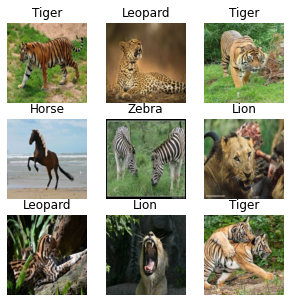

In [ ]:
visualise_data = train_ds.take(1)
plt.figure(figsize=(5, 5))
for image, label in visualise_data:
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      img = image[i]/255.
      plt.imshow(img)
      plt.title(class_names[label[i].numpy().argmax()])
      plt.axis("off")

### **Preprocessing Data Functions**

In [ ]:
SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE

@tf.function
def preprocess_train(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.resize(image, (RESIZE_TO, RESIZE_TO))
    image = tf.image.random_crop(image, (BATCH_SIZE,CROP_TO, CROP_TO, 3))
    image = image / 255.0
    return (image, label)


@tf.function
def preprocess_test(image, label):
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = image / 255.0
    return (image, label)


DATASET_NUM_TRAIN_EXAMPLES = train_ds.cardinality().numpy()

repeat_count = int(
    SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH
)
repeat_count += 50 + 1  # To ensure at least there are 50 epochs of training

## **Define the data pipeline**

In [ ]:
# Training pipeline
pipeline_train = (
    train_ds.shuffle(400)
    .repeat(repeat_count)  # Repeat dataset_size / num_steps
    .map(preprocess_train, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

# Validation pipeline
pipeline_validation = (
    val_ds.map(preprocess_test, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

### **Visualise Augumented Training Samples**

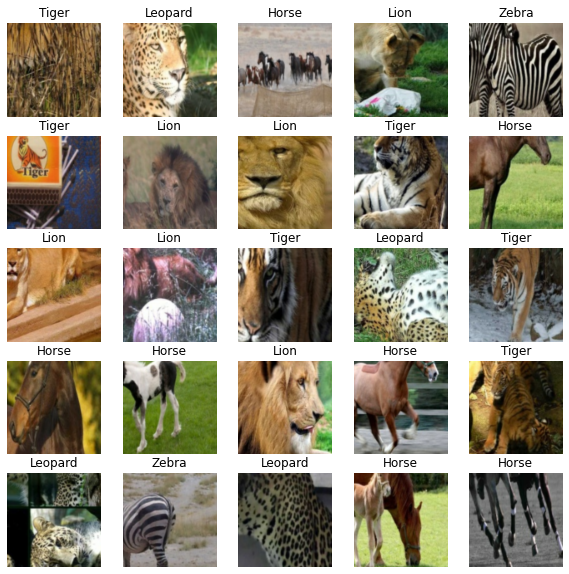

In [ ]:
image_batch, label_batch = next(iter(pipeline_train))

plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(image_batch[n])
    tit = class_names[int(np.array(label_batch[n]).argmax())]
    plt.title(tit)
    plt.axis("off")

## **Load pretrained TF-Hub model into a KerasLayer**

In [ ]:
bit_model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
bit_module = hub.KerasLayer(bit_model_url)

## ** Create BigTransfer model**

In [ ]:
class MyBiTModel(keras.Model):
    def __init__(self, num_classes, module, **kwargs):
        super().__init__(**kwargs)

        self.num_classes = num_classes
        self.head = keras.layers.Dense(num_classes, activation = 'softmax', kernel_initializer="zeros")
        self.bit_model = module


    def call(self, images):
        bit_embedding = self.bit_model(images)
        return self.head(bit_embedding)


model = MyBiTModel(num_classes=NUM_CLASSES, module=bit_module)

# **Define optimizer and loss**

In [ ]:
learning_rate = 0.003 * BATCH_SIZE / 512

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES,
    values=[
        learning_rate,
        learning_rate * 0.1,
        learning_rate * 0.01,
        learning_rate * 0.001,
    ],
)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = keras.losses.CategoricalCrossentropy()

### **Compile Model**

In [ ]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

### **CallBack**

In [ ]:
train_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=2, restore_best_weights=True
    )
]

### **Train the model**

In [ ]:
history = model.fit(
    pipeline_train,
    epochs=int(SCHEDULE_LENGTH / STEPS_PER_EPOCH),
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=pipeline_validation,
    callbacks=train_callbacks
)

### **Save and Download Model**

In [ ]:
# Save the model
model.save('model-1',save_format='tf')

In [ ]:
!zip -r /content/model-1.zip /content/model-1

from google.colab import files
files.download("/content/model-1.zip")